<a href="https://colab.research.google.com/github/mifm/examples/blob/master/cable_layout_with_edwin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [ ]:
!pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git

In [ ]:
!pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from topfarm import TopFarmProblem, TopFarmGroup
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.plotting import XYPlotComp
from topfarm.cost_models.cost_model_wrappers import CostModelComponent

from py_wake.deficit_models.gaussian import BastankhahGaussian
from py_wake.utils.gradients import autograd
from py_wake.validation.lillgrund import wt_x, wt_y, LillgrundSite, ct_curve, power_curve
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

from ed_win.wind_farm_network import WindFarmNetwork, TwoStepHeuristicDriver, Refine, Repair

In [ ]:
wind_turbines = WindTurbine('SWT2p3_93_65', 92.6, 65, PowerCtTabular(ct_curve[:,0],power_curve[:,1], 'kW', ct_curve[:,1]))
n_wt = len(wt_x)
site = LillgrundSite()
substation_positions = np.asarray([[359470], [6153890]])
settings = {'option': 3,
            'Inters_const': True,
            'max_it': 20000,
            'repair': True}
cables = np.array([[500, 3, 100000], [800, 5, 150000], [1000, 10, 250000], [1100, 18, 400000]])
wfn = WindFarmNetwork(turbine_positions=np.asarray([wt_x, wt_y]),
                      substation_positions=substation_positions,
                      drivers=[TwoStepHeuristicDriver(**settings), Refine(), Repair()],
                      sequence=[0, 2, 1],
                      cables=cables)
def cable_func(x, y, **kwargs):
    wfn.design(np.asarray([x, y]))
    return wfn.T[:, 2].sum()  # total cable length

cable_comp = CostModelComponent(['x', 'y'], n_wt, cable_func, output_keys=['cable_length'], objective=False)
max_cable_length = 15300
wf_model = BastankhahGaussian(site, wind_turbines)
constraint_comp = XYBoundaryConstraint(np.asarray([wt_x, wt_y]).T)
aep_comp = PyWakeAEPCostModelComponent(windFarmModel=wf_model,
                                        n_wt=n_wt,
                                        grad_method=autograd)
cost_comp = TopFarmGroup([cable_comp, aep_comp])
problem = TopFarmProblem(design_vars={'x': wt_x, 'y': wt_y},
                        constraints=[constraint_comp, SpacingConstraint(min_spacing=wind_turbines.diameter() * 2),
                                      ('cable_length', {'upper': max_cable_length})],
                        cost_comp=cost_comp,
                        driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=10),
                        plot_comp=XYPlotComp())

In [ ]:
cost, state, recorder = problem.optimize(disp=True)

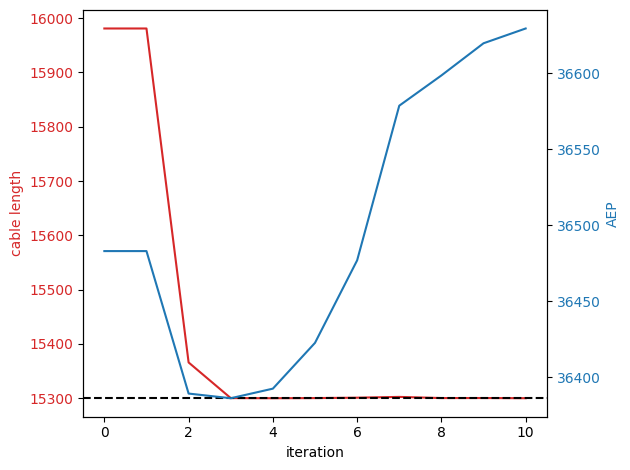

In [7]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('iteration')
ax1.set_ylabel('cable length', color=color)
ax1.plot(recorder['cable_length'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.axhline(y=max_cable_length, xmin=0, xmax=recorder['cable_length'].size, color='black', linestyle='--')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('AEP', color=color)  # we already handled the x-label with ax1
ax2.plot(recorder['AEP'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


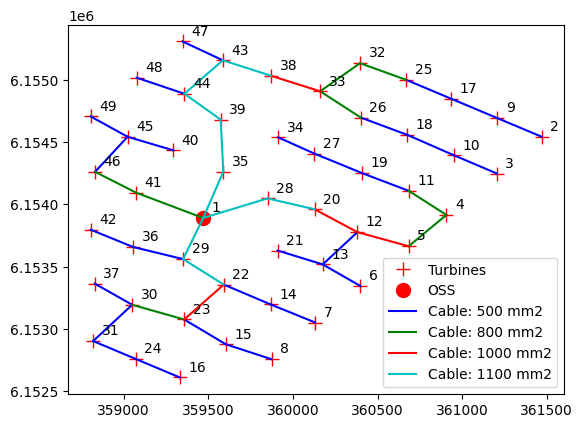

In [8]:
wfn.plot()